# Machine Learning Model 배포

모델 배포는 기계 학습 수명 주기의 마지막 단계 중 하나입니다. 이 실습에서는 [`YOLOV3`](https://pjreddie.com/darknet/yolo/)라는 사전 훈련된 모델을 사용합니다. 이 모델은 실행 속도가 빠르고 사진에서 일반적인 개체를 감지하도록 훈련된 컴퓨터 비전 모델입니다. 

작업의 순서는 다음과 같습니다.  

1. object detection에 사용된 이미지 데이터 세트 검사
2. 모델 자체 살펴보기
3. [`fastAPI`](https://fastapi.tiangolo.com/)를 사용하여 모델 배포

## YOLOV3 를 이용한 객체 검출 (Object Detection)

YOLOV3 모델에 전달할 이미지를 살펴보겠습니다. 이 이미지들은 [`ImageNet`](http://www.image-net.org/index) 데이터 세트의 일부입니다.


airplane.jpg


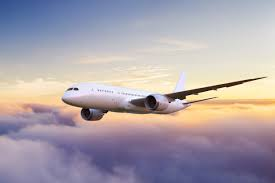


apple.jpg


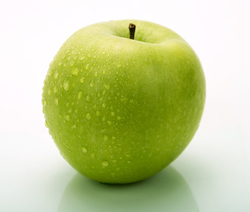


apples.jpg


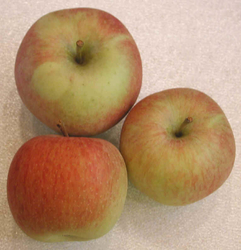


bike.jpg


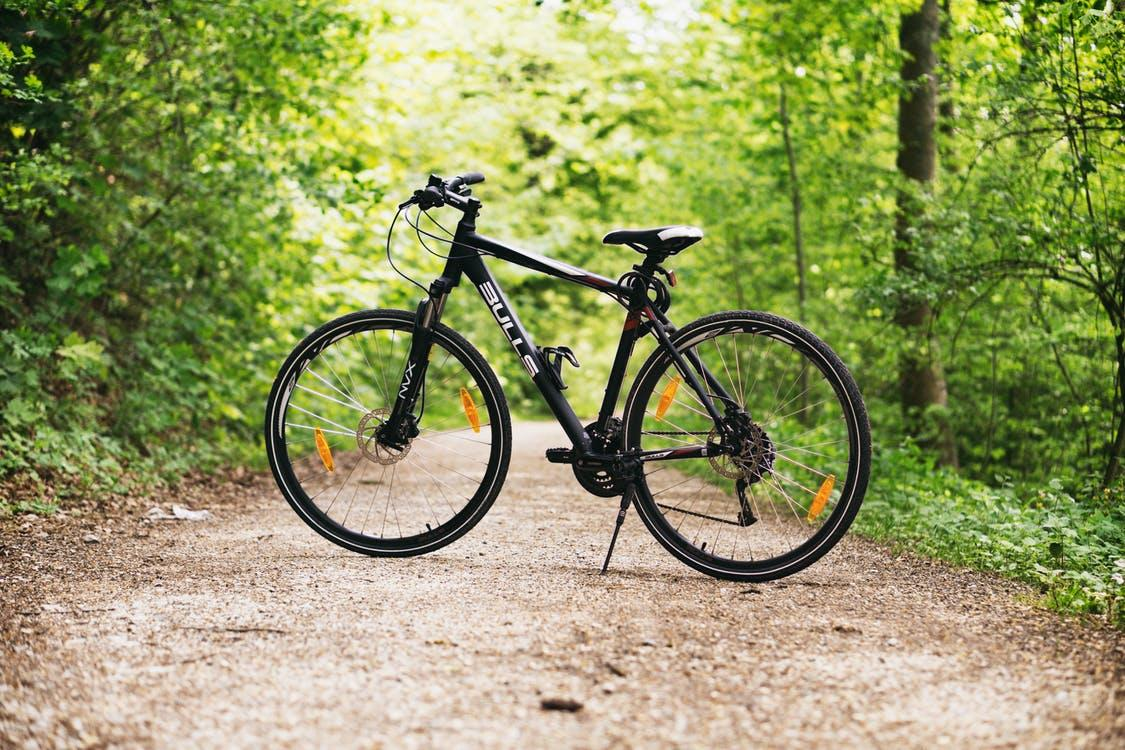


car.jpg


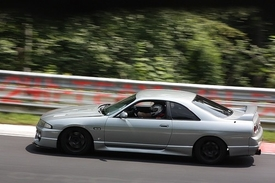


car1.jpg


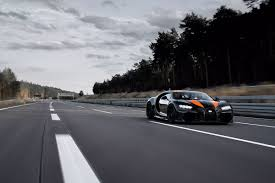


car2.jpg


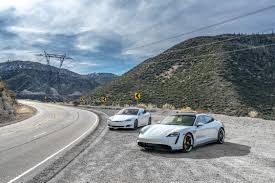


car3.jpg


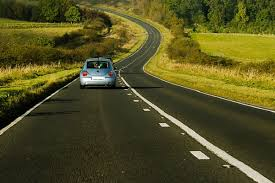


clock.jpg


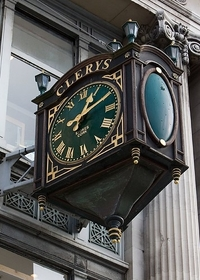


clock2.jpg


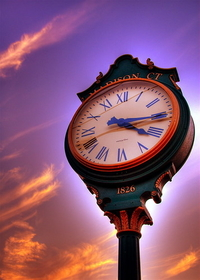


clock3.jpg


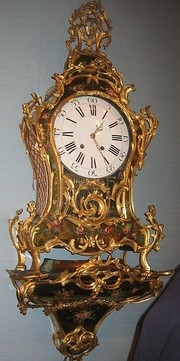


dog.jpg


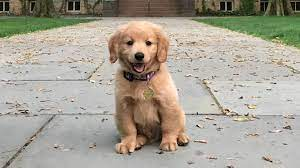


fruits.jpg


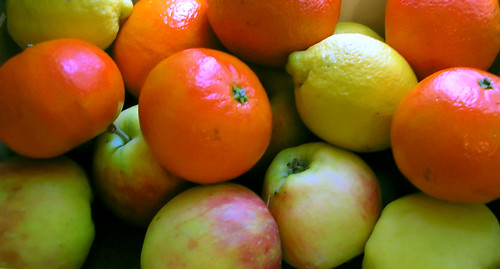


horse.jpg


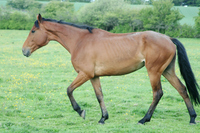


oranges.jpg


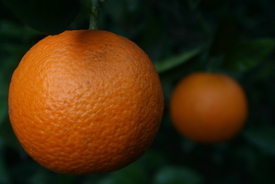


person.jpg


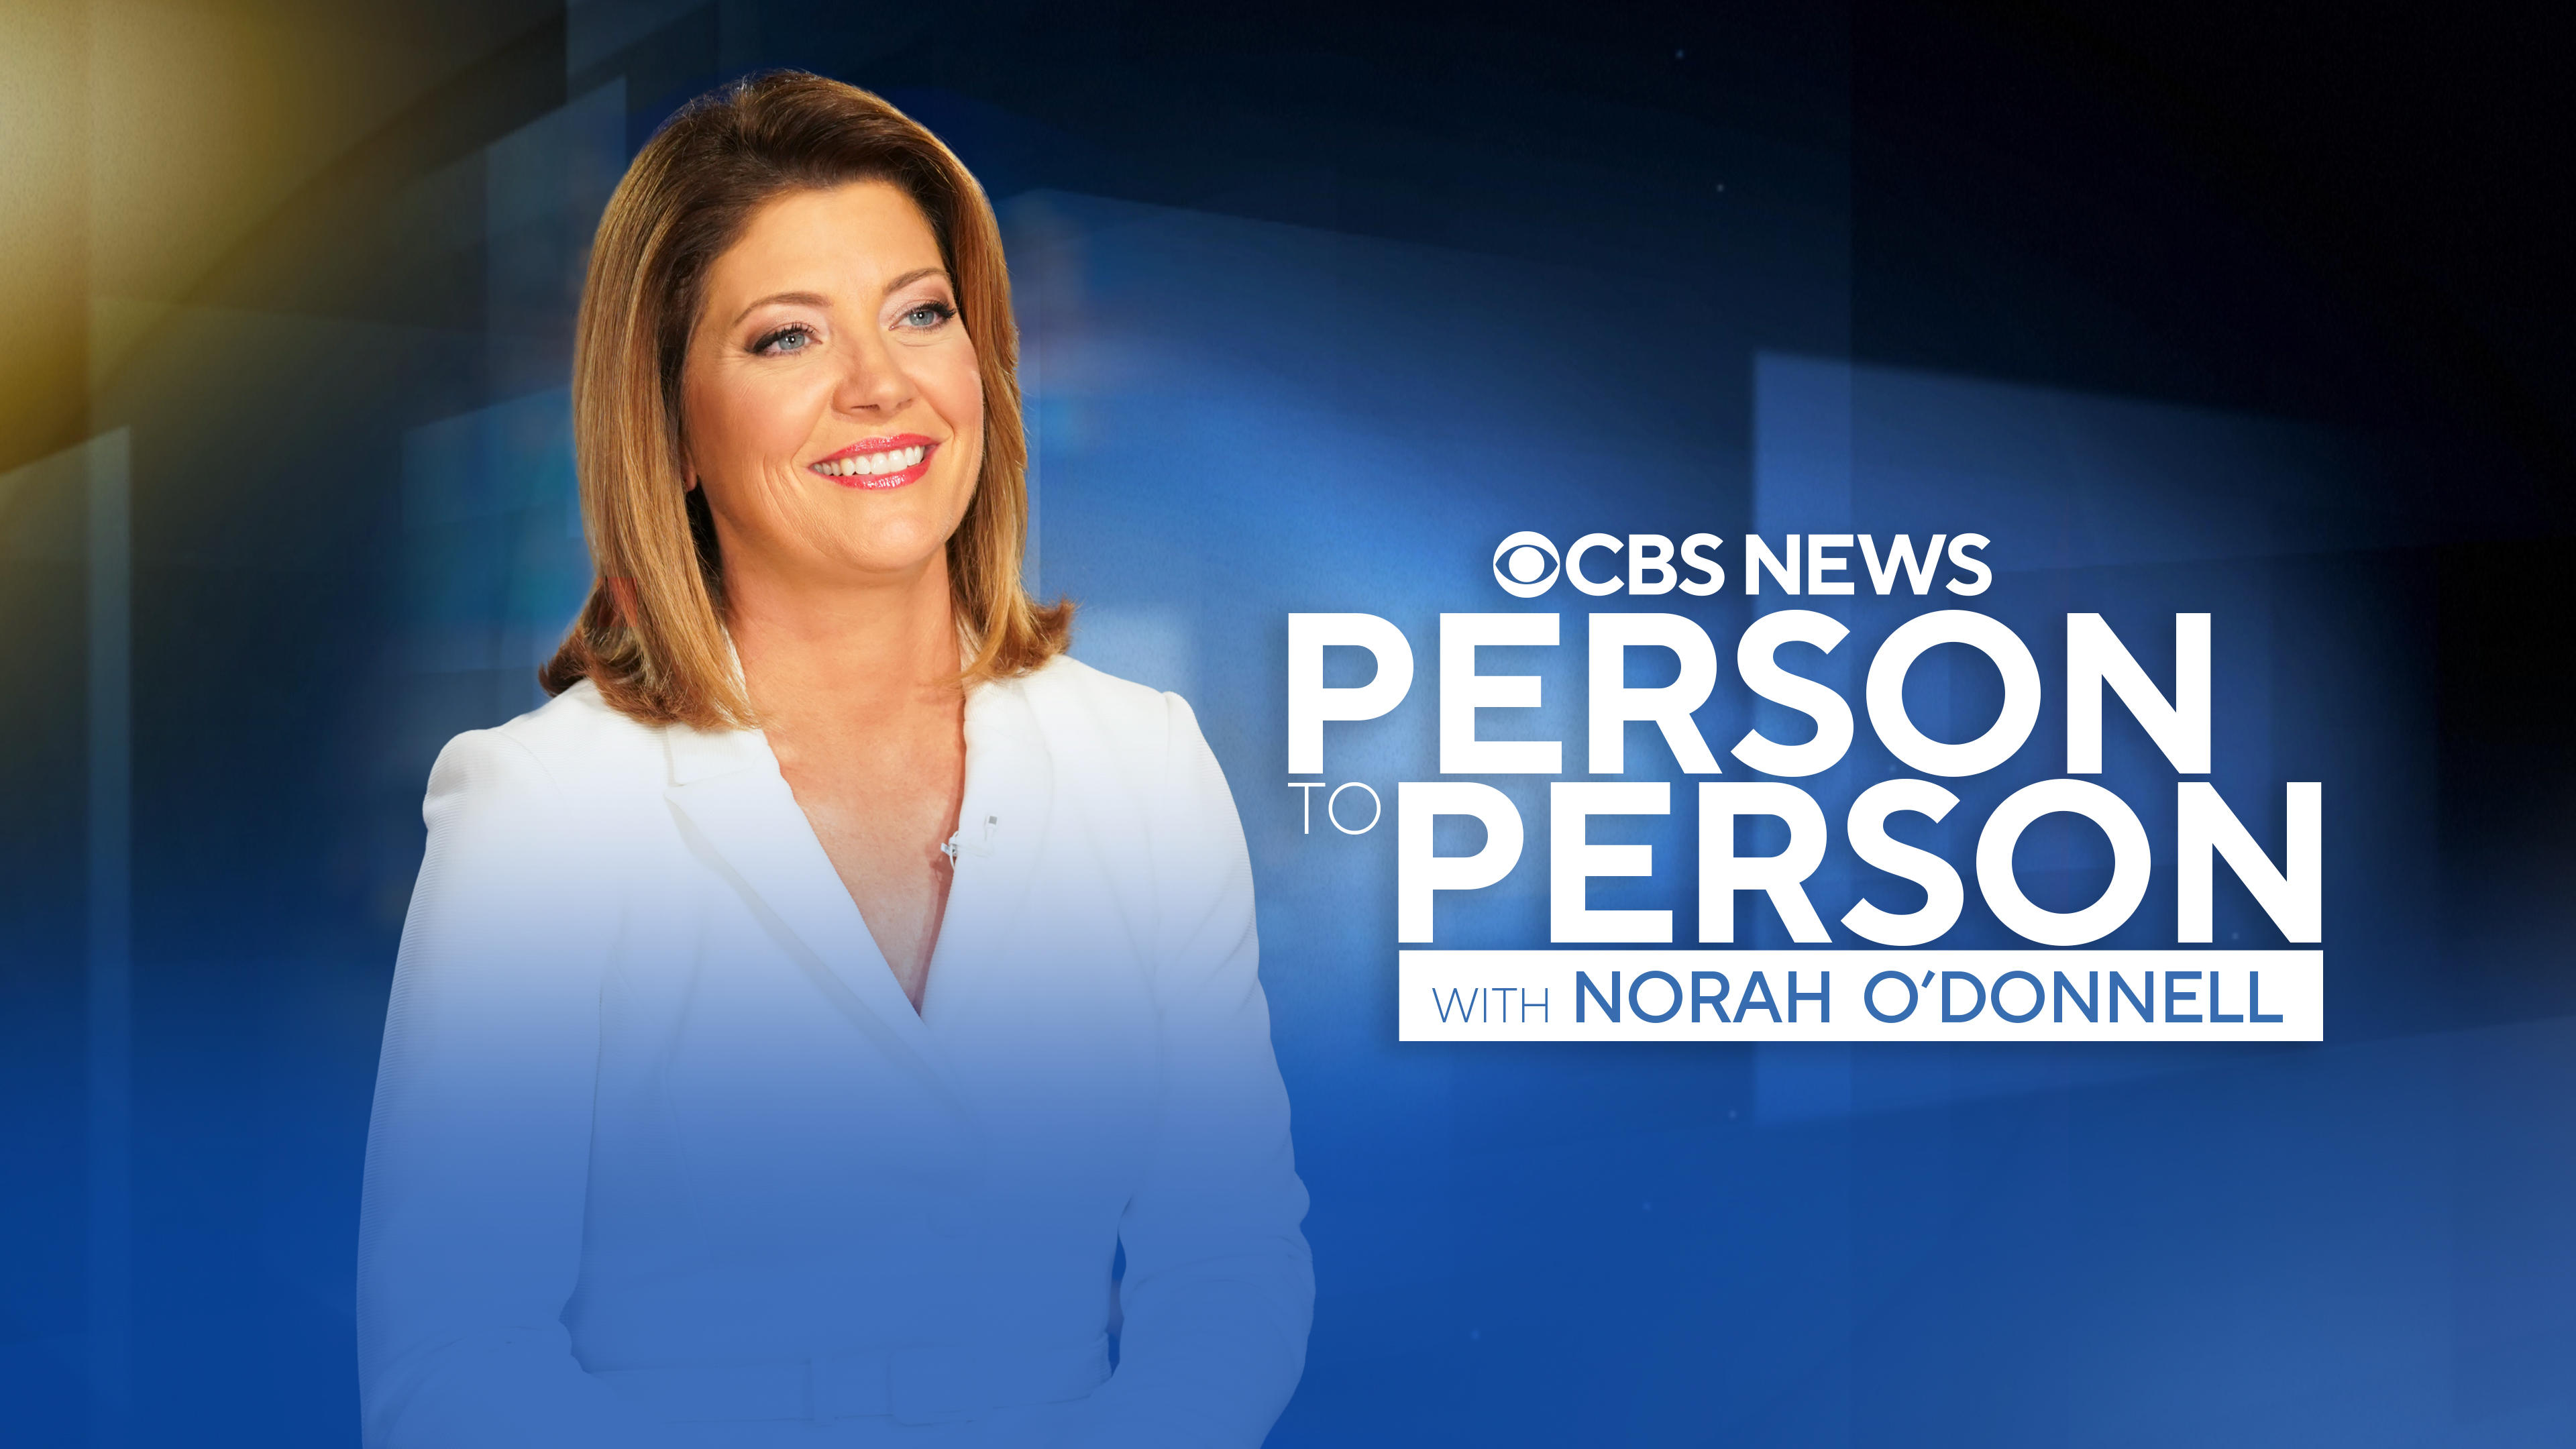

In [15]:
from IPython.display import Image, display
import os

# 'images' 폴더의 모든 파일 목록을 가져옵니다.
image_files = os.listdir('images')

for image_file in image_files:
    # 이미지 파일 이름을 출력합니다.
    print(f"\n{image_file}")
    # 이미지 파일을 표시합니다.
    display(Image(filename=f"images/{image_file}"))

### Overview of the model

모델이 object를 올바르게 감지하고 분류할 수 있는지 확인하기 위해  객체 감지 라이브러리인 [`cvlib`](https://www.cvlib.net/)을 사용합니다. cvlib은 얼굴, 객체 인식을 위한 사용하기 쉬운 라이브러리인데 OpenCV 와 tensorflow 로 작성된 라이브러리이므로 2 가지를 함께 설치해야 합니다.

numpy array format의 이미지를 받아 다음을 반환하는 [`detect_common_objects`](https://docs.cvlib.net/object_detection/) 함수를 사용합니다.
```
import cvlib as cv
from cvlib.object_detection import draw_bbox

bbox, label, conf = cv.detect_common_objects(img)

output_image = draw_bbox(img, bbox, label, conf)
```

- `bbox`: 감지된 개체에 대한 bounding box 좌표가 포함된 list 입니다. 
        Example:  [[32, 76, 128, 192], [130, 83, 220, 185]]
    

- `label`: 감지된 object의 label 의 list
        Example:  ['apple', 'apple']


- `conf`: 감지된 개체에 대한 confidence score 목록
        Example:   [0.6187325716018677, 0.42835739254951477]

### detect_and_draw_box 함수 만들기

개체 감지 모델을 사용하기 전에 결과 이미지를 저장할 수 있는 디렉터리를 만듭니다.

In [16]:
dir_name = "images_with_boxes"

# 디렉토리가 존재하지 않는 경우 디렉토리를 생성
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

시스템에 있는 파일의 **filename**, **model**, **confidence level**을 입력 인수로 사용하는 `detect_and_draw_box` 함수를 정의해 보겠습니다. 이러한 입력을 통해 이미지에서 일반적인 객체를 감지하고 감지된 객체와 함께 bounding box를 표시하는 새 이미지를 저장합니다.

confidence level은 이미지에 개체가 존재할 확률입니다. 

In [17]:
!pip install opencv-python 
!pip install cvlib

In [18]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox

def detect_and_draw_box(filename, model="yolov4", confidence=0.5):
    """이미지에서 일반적인 object를 감지하고
       bounding box가 있는 새 이미지 만들기."""
    
    img_filepath = f'images/{filename}'  # 이미지 파일 경로 지정
    
    img = cv2.imread(img_filepath)  # 이미지를 numpy 배열로 읽기
    img = cv2.resize(img, (250, 250))  # 이미지를 250x250 크기로 리사이즈
    print(img.shape)  # 이미지의 형태 출력
    
    # 객체 탐지 수행. 탐지된 객체의 신뢰도가 confidence 값 이상일 때만 결과로 반환
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    print(f"========================\n이미지 처리 완료: {filename}\n")
    
    # 탐지된 각 객체에 대해 레이블과 신뢰도 출력
    for l, c in zip(label, conf):
        print(f"검출된 객체: {l} - confidence level: {c:.2f}\n")
    
    # bounding box를 포함하는 새 이미지 만들기
    output_image = draw_bbox(img, bbox, label, conf)

    # 새로운 이미지 저장
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # bounding box가 추가된 이미지 표시
    display(Image(f'images_with_boxes/{filename}'))

(250, 250, 3)
이미지 처리 완료: airplane.jpg

검출된 객체: airplane - confidence level: 0.99



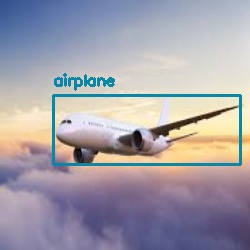

(250, 250, 3)
이미지 처리 완료: apple.jpg

검출된 객체: apple - confidence level: 0.81



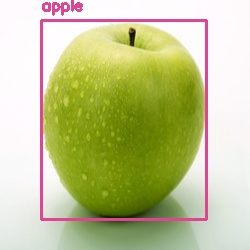

(250, 250, 3)
이미지 처리 완료: apples.jpg

검출된 객체: apple - confidence level: 0.91

검출된 객체: apple - confidence level: 0.90

검출된 객체: apple - confidence level: 0.76



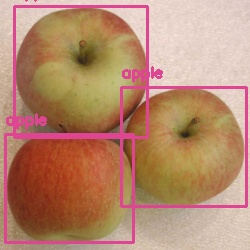

(250, 250, 3)
이미지 처리 완료: bike.jpg

검출된 객체: bicycle - confidence level: 1.00



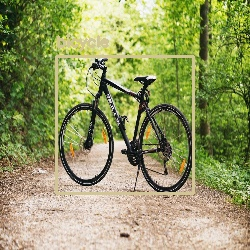

(250, 250, 3)
이미지 처리 완료: car.jpg

검출된 객체: car - confidence level: 0.99



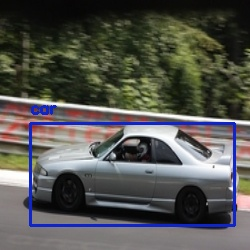

(250, 250, 3)
이미지 처리 완료: car1.jpg

검출된 객체: car - confidence level: 0.97



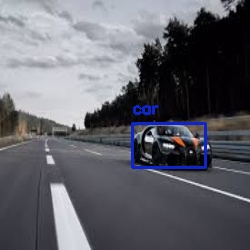

(250, 250, 3)
이미지 처리 완료: car2.jpg

검출된 객체: car - confidence level: 1.00

검출된 객체: car - confidence level: 0.99



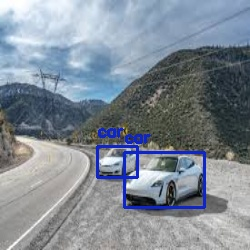

(250, 250, 3)
이미지 처리 완료: car3.jpg

검출된 객체: car - confidence level: 1.00



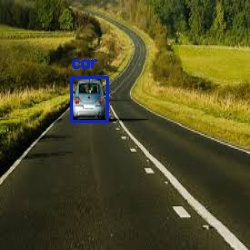

(250, 250, 3)
이미지 처리 완료: clock.jpg

검출된 객체: clock - confidence level: 0.96

검출된 객체: clock - confidence level: 0.94



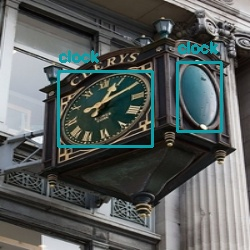

(250, 250, 3)
이미지 처리 완료: clock2.jpg

검출된 객체: clock - confidence level: 0.93



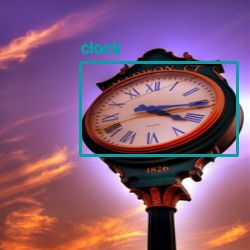

(250, 250, 3)
이미지 처리 완료: clock3.jpg

검출된 객체: clock - confidence level: 0.98



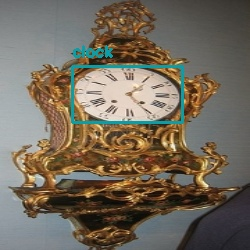

(250, 250, 3)
이미지 처리 완료: dog.jpg

검출된 객체: dog - confidence level: 0.98



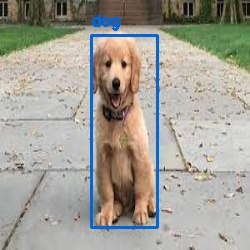

(250, 250, 3)
이미지 처리 완료: fruits.jpg

검출된 객체: orange - confidence level: 0.71

검출된 객체: apple - confidence level: 0.65

검출된 객체: apple - confidence level: 0.51



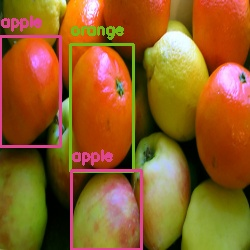

(250, 250, 3)
이미지 처리 완료: horse.jpg

검출된 객체: horse - confidence level: 1.00



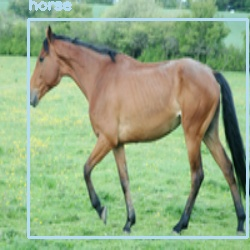

(250, 250, 3)
이미지 처리 완료: oranges.jpg

검출된 객체: orange - confidence level: 0.98

검출된 객체: orange - confidence level: 0.78



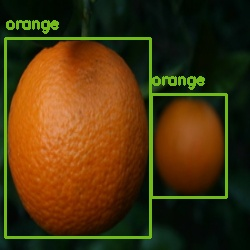

(250, 250, 3)
이미지 처리 완료: person.jpg

검출된 객체: person - confidence level: 0.92



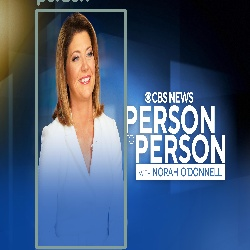

In [19]:
for image_file in image_files:
    detect_and_draw_box(image_file)

## fastAPI 를 이용한 model serving

In [20]:
# 새 디렉토리 이름을 지정합니다.
dir_name = "images_uploaded"

# 디렉토리가 존재하지 않는 경우 디렉토리를 생성
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

## 모델 배포에 필요한 사전 지식

### Client-Server model

- **deploying** - prediction에 필요한 모든 소프트웨어를 'server'에 설치하는 것. 이렇게 하면 'client'가 서버에 'request'를 보내 모델과 상호 작용할 수 있습니다.

- client는 모델이 예측을 수행하는 데 필요한 정보를 제공. server는 제공된 정보를 사용하여 클라이언트에게 예측을 반환.

- **FastAPI** 클래스의 인스턴스를 만들어 시작합니다.

```python
app = FastAPI()
```

- 다음 단계는 이 인스턴스를 사용하여 예측 논리를 처리할 endpoint(path, route)를 만드는 것입니다. 서버를 실행하기 위한 모든 코드가 준비되면 다음 명령만 사용하면 됩니다.

```python
uvicorn.run(app)
```

- serving은 [`uvicorn`](https://www.uvicorn.org/)을 사용하여 수행되며 uvicorn은 ASGI web server 입니다. ASGI(Asynchronous Server Gateway Interface   - 비동기 Python 웹 서버)

### endpoints (path, route)

동일한 서버에서 여러 기계 학습 모델을 호스팅할 수 있습니다. 이것이 작동하려면 각 모델에 다른 `endpoint`를 할당합니다. endpoint는 'URL' 패턴으로 표시됩니다. 예를 들어 `imagetest.com`이라는 웹 사이트가 있는 경우 다음 엔드포인트에 세 가지 다른 모델을 지정할 수 있습니다.

- `imagetest.com/lenet/`
- `imagetest.com/yolo/`
- `imagetest.com/mobilenet/`

fastAPI에서는 해당 endpoint에 대한 모든 logic을 처리할 함수를 만들고  endpoint를 [decorating](https://www.python.org/dev/peps/pep-0318/) 합니다. 

다음 예는 엔드포인트 "/my-endpoint"에 대한 HTTP GET 요청을 허용하는 방법을 보여줍니다.

```python
@app.get("/my-endpoint")
def handle_endpoint():
    ...
    ...
```

### HTTP Requests

- `GET` -> 서버에서 정보 검색  
- `POST` -> 응답에 필요한 정보를 서버에 제공

endpoint에 있는 기계 학습 모델과은 일반적으로 예측을 계산하는 데 필요한 정보를 제공해야 하기 때문에 `POST request`를 통해 수행됩니다.

```python
@app.post("/my-other-endpoint")
def handle_other_endpoint(param1: int, param2: str):
    ...
    ...

```
### Why fastAPI?

fastAPI를 사용하면 웹 서버를 생성하여 모델을 매우 쉽게 호스팅할 수 있습니다. 또한 이 플랫폼은 매우 빠르며 **서버와 상호 작용하는 데 사용할 수 있는 클라이언트가 내장되어 있습니다**. 

In [25]:
# !pip install uvicorn
# !pip install fastapi
# !pip install python-multipart

In [22]:
import io  # 입출력(I/O) 작업을 위한 표준 라이브러리
import uvicorn  # ASGI 서버를 실행하기 위한 라이브러리
import numpy as np  
import nest_asyncio  # Jupyter Notebook과 같은 환경에서 비동기 이벤트 루프를 중첩하여 사용하기 위한 패키지
from enum import Enum  # 열거형(Enum) 클래스를 정의하기 위한 표준 라이브러리
from fastapi import FastAPI, UploadFile, File, HTTPException  # FastAPI 프레임워크, 파일 업로드 및 HTTP 예외 처리를 위한 모듈
from fastapi.responses import StreamingResponse  # 스트리밍 응답을 위한 FastAPI 모듈

In [23]:
app = FastAPI(title='FastAPI를 이용한 ML model deploy')

#str과 Enum 클래스를 상속받아 Model이라는 새로운 열거형(Enum) 클래스를 정의
class Model(str, Enum):
    yolov4tiny = "yolov4-tiny"
    yolov4 = "yolov4"

@app.get("/")  # 루트 URL ("/")에 대한 GET 요청을 처리하는 엔드포인트 정의
def home():
    # 클라이언트에게 반환할 메시지 정의
    return "API 가 정상 작동하고 있습니다. http://localhost:8000/docs 로 이동하세요."


@app.post("/predict") # "/predict" 경로에 대한 POST 요청을 처리하는 엔드포인트 정의
def prediction(model: Model, file: UploadFile = File(...)):
    """
    매개변수:
    - model: 사용자가 선택한 모델 (yolov4-tiny 또는 yolov4) --> 열거형(Enum) 클래스의 인스턴스
    - file: 업로드된 이미지 파일 --> UploadFile 클래스의 인스턴스
            File(...)은 이 매개변수가 파일 업로드를 요구하며 기본값을 가지지 않음을 의미
    """

    # 1. INPUT FILE 확인
    
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="지원하지 않는 파일 타입 입니다.")
    
    # 2.  RAW IMAGE를 CV2 image로 변환
    
    image_stream = io.BytesIO(file.file.read())  # 업로드된 파일을 바이트 스트림으로 읽습니다.
    image_stream.seek(0)   # 스트림의 위치를 처음(0 위치)으로 되돌립니다.
    
    # numpy 배열로 bytes stream 쓰기
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # numpy 배열을 이미지로 디코딩
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    # 3. OBJECT DETECTION MODEL 실행
    
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # bounding box와 레이블이 포함된 이미지를 만들어 저장
    output_image = draw_bbox(image, bbox, label, conf)
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    # 4. CLIENT로 Respond
    
    # 저장된 이미지를 binary mode로 읽기
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # 미디어 type을 지정하여 스트림으로 이미지 반환
    return StreamingResponse(file_image, media_type="image/jpeg")

- 다음 셀을 실행하면 서버가 가동됩니다. 이로 인해 커널을 수동으로 중단할 때까지 노트북이 차단됩니다(셀/코드가 실행될 수 없음)
- `Kernel` -->  `Interrupt`를 클릭하거나 `ESC'` 키를 누르고 `I` 키를 두 번 눌러 interrupt 할 수도 있습니다.  
- `nest_asyncio`는 Jupyter notebook에서 `uvicorn`이 실행될 수 있도록 합니다. 

In [24]:
# Jupyter notebook 환경에서 서버를 실행할 수 있습니다.
nest_asyncio.apply()

host = "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [9136]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:60176 - "POST /predict?model=yolov4-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:60182 - "POST /predict?model=yolov4-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:60184 - "POST /predict?model=yolov4-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:60186 - "POST /predict?model=yolov4-tiny HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [9136]


- [http://localhost:8000/](http://localhost:8000/)로 이동하여 서버가 작동하는 것을 확인합니다.

- image를 제출하여 API가 이미지 안의 객체를 감지하고 감지된 객체의 레이블과 함께 bounding box가 포함된 새 이미지를 반환하는 하는 것을 확인
- [http://localhost:8000/docs](http://localhost:8000/docs)를 방문하여 fastAPI의 내장 client 사용

`/predict` endpoint 상단을 클릭하면 더 많은 옵션이 표시됩니다.

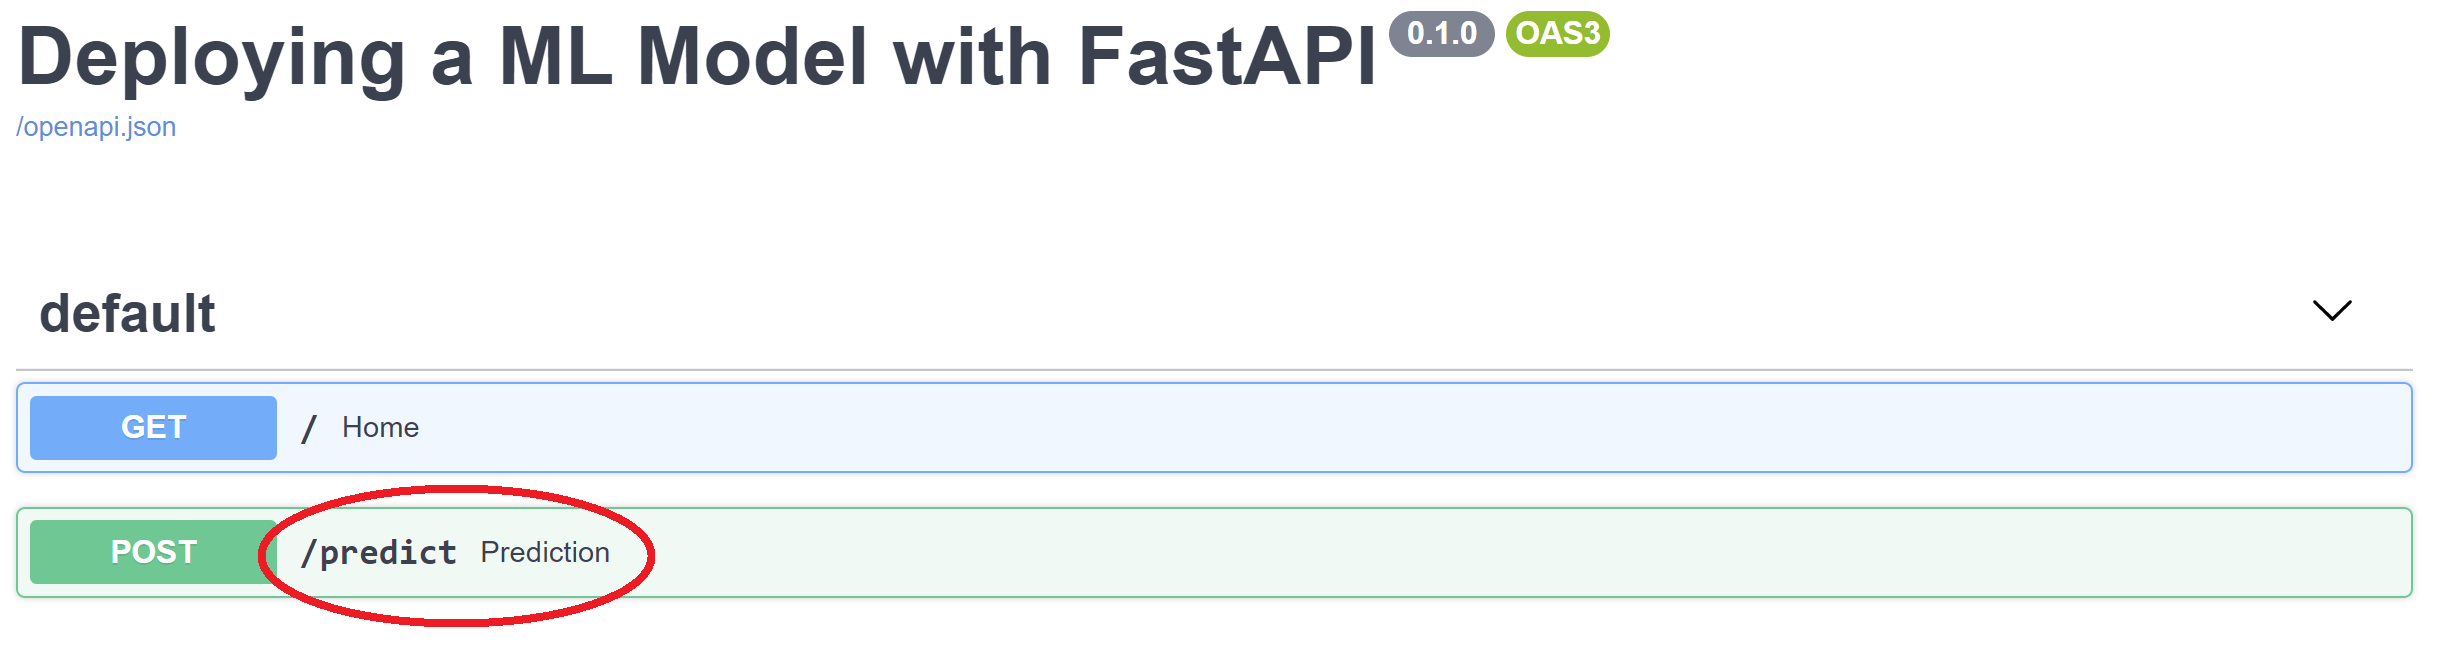



**Try it out** 버튼을 클릭하여 server를 test 합니다.

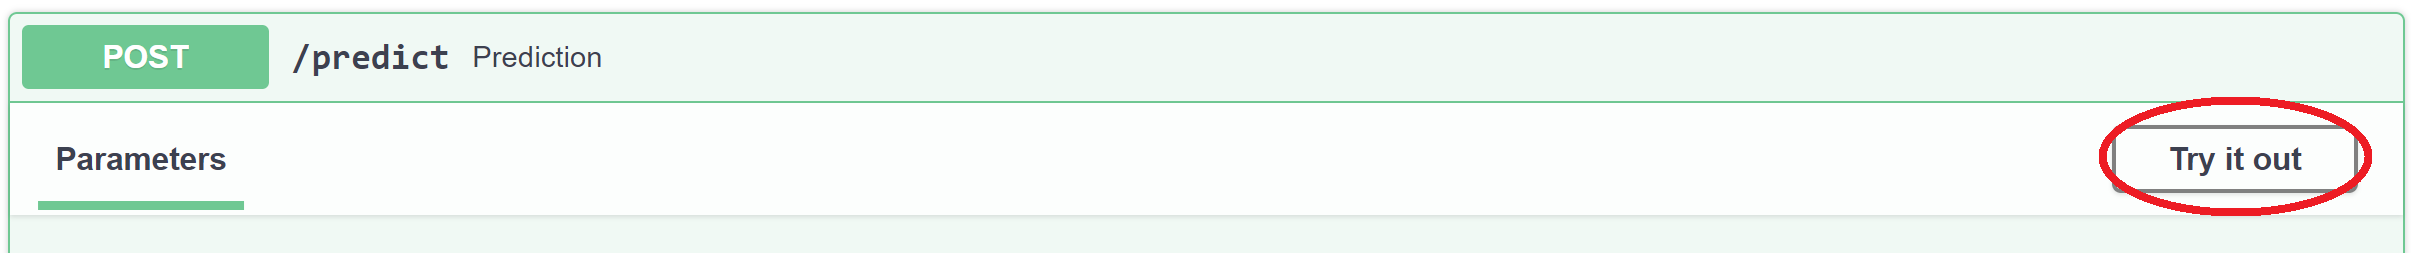

**model** 필드(전체 YOLO 모델을 선택하면 이 모델의 가중치가 다운로드될 때까지 서버가 중단됨) 및 **file**에서 모델을 선택하여 서버가 개체를 감지하게 합니다.

**파일 선택** 버튼을 클릭하여 로컬 파일 시스템에서 **이미지를 제출**한 다음 파란색 **실행** 버튼을 클릭하여 서버에 HTTP 요청을 보냅니다. 그렇게 한 후 **아래로 스크롤하면 응답을 볼 수 있습니다**. 

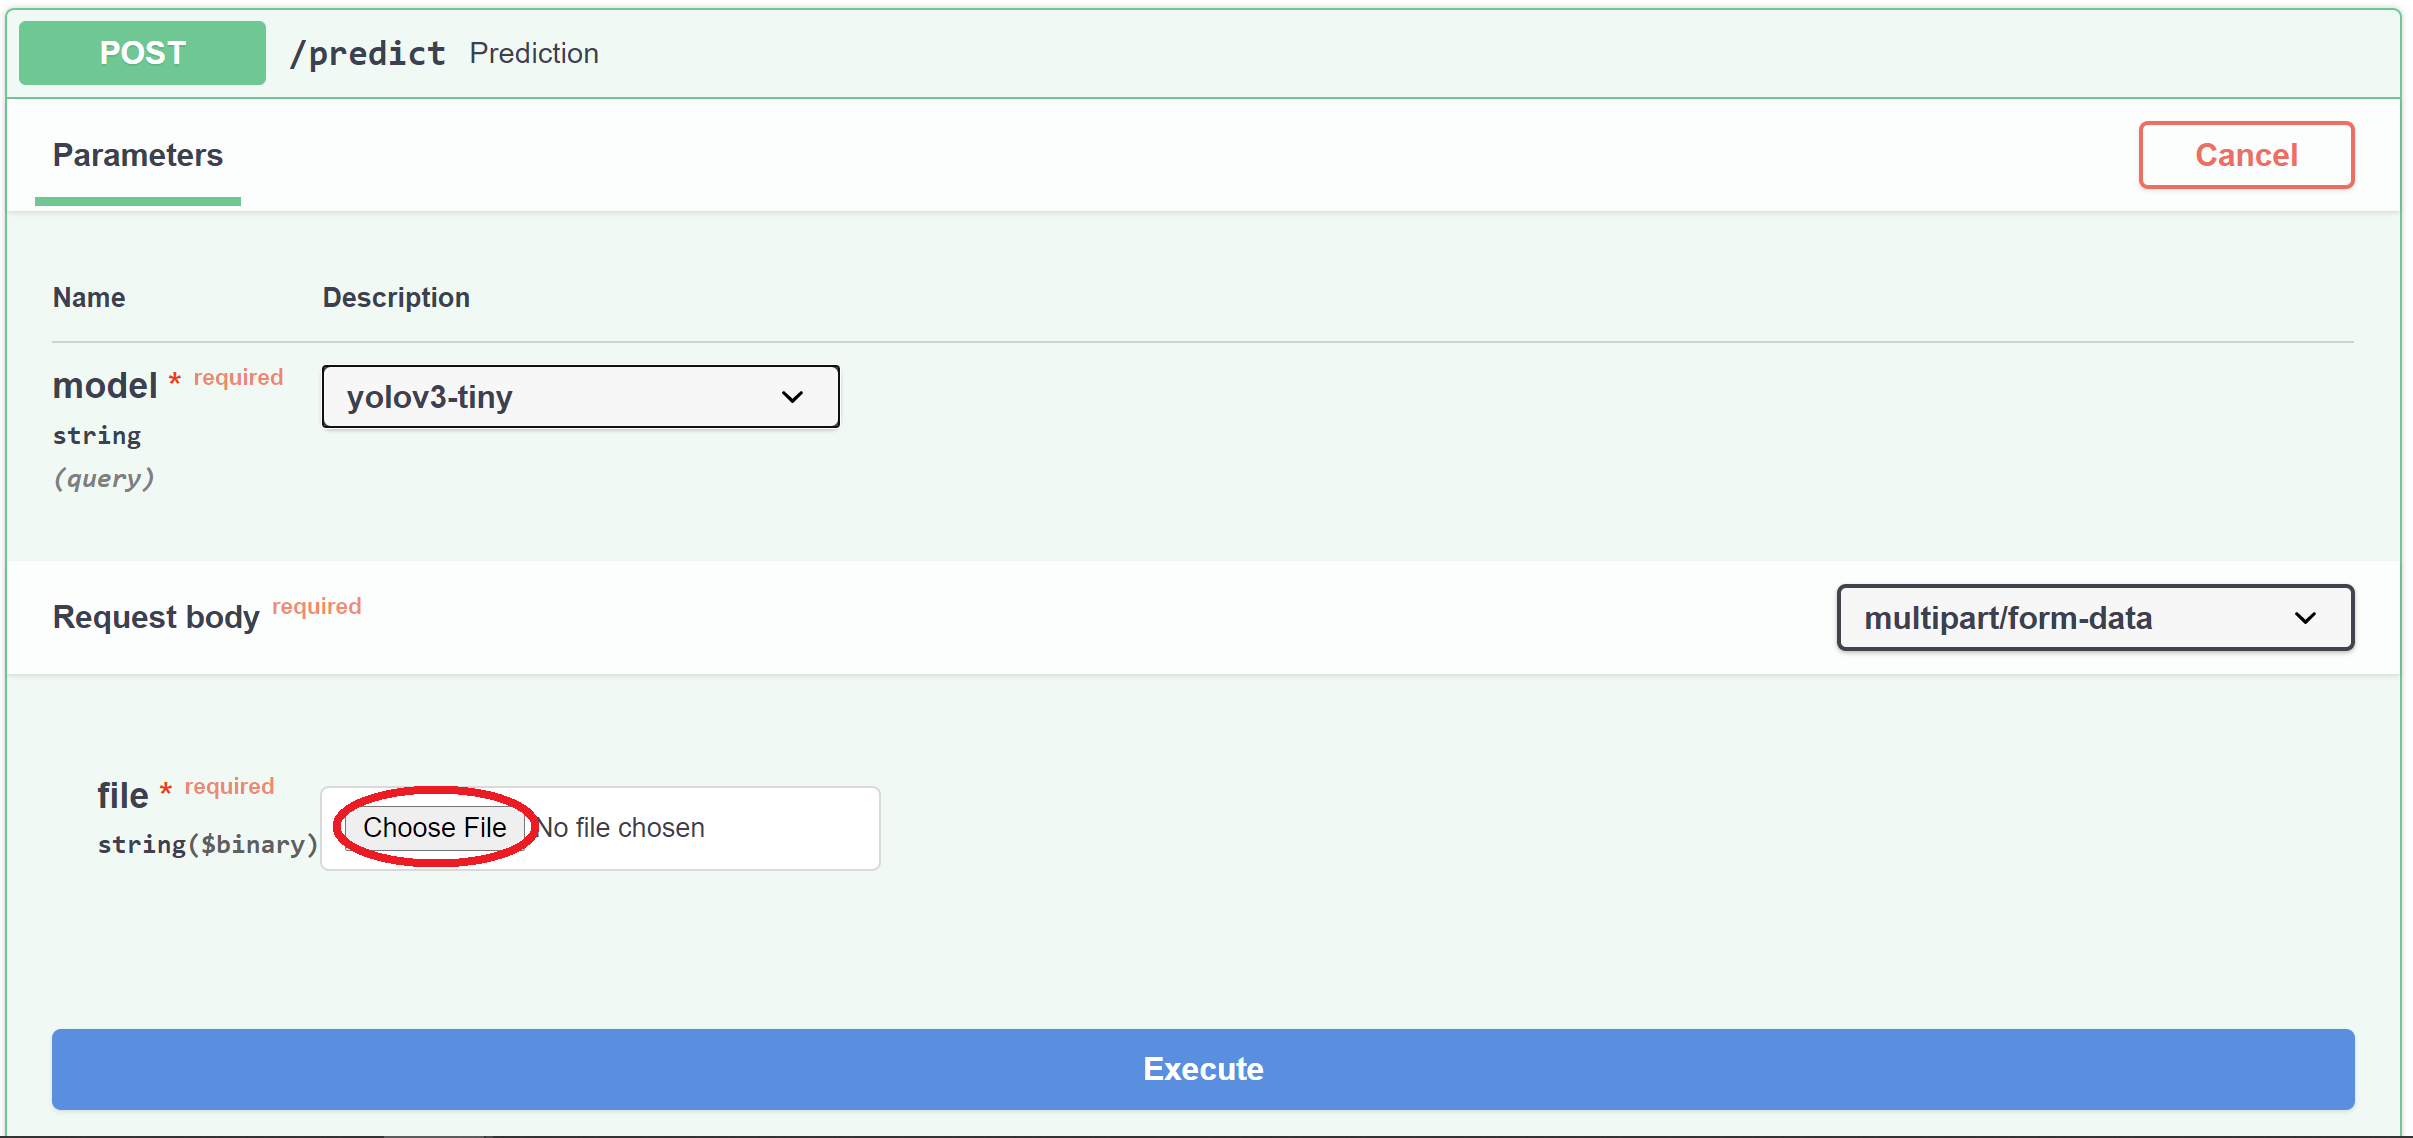

**다른 이미지를 사용해 보세요!** 이 실습에서 제공한 이미지나 각자의 이미지를 사용할 수 있습니다. 모델이 기본 신뢰 수준 0.5를 사용하고 있기 때문에 일부 개체를 감지하는 데 항상 성공하지 못할 수도 있습니다.

또한 이미지가 아닌 파일을 제출하고 서버가 이에 대해 어떻게 반응하는지 확인하십시오.

## 다른 client에서 model 이용

fastAPI를 사용하면 내장 클라이언트를 통해 API와 상호 작용할 수 있습니다.  일반 코드를 사용하여 API와 상호 작용할 수도 있습니다.

이를 위해 서버를 실행 중인 상태로 두고 `client.ipynb` 노트북을 엽니다. 